### The libraries imported in the next cell are libraries used to solve the probelm and visulaization


In [483]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import xgboost
import numpy as np



# Data Exploration Part
### 1. **read_diff_files** method takes the  **input** realtive path of the train, test file and **return** both the train and the test dataframe
### 2. **data_exploration** method takes as **input** the dataframe and **return** the col with nulls as perc as well as the different data types
### 3. **features_types** method takes as **input** dataframe and **return** the number of categorical, numeical and float features
### 4. **check_missing_vlaues_per_data_type** method takes as **input** the dataframe and a spefic datatype and **returns** the percentage of null values in that dataframe associated with the specfic datatype
### 5. **drop_features** method takes as **input** the dataframe and a certain thresold and **return** a dataframe with dopped features with features missing values more than the threshold



In [484]:
def read_diff_files(data_dir, train_file, test_file,sample_submission):
    current_directory = os.getcwd()
    path_to_data = current_directory + data_dir  
    df_train = pd.read_csv(path_to_data + train_file)
    df_test = pd.read_csv(path_to_data+test_file)
    df_sam_subm = pd.read_csv(path_to_data+sample_submission)  
    return df_train,df_test,df_sam_subm

df_train,df_test,df_sam_subm = read_diff_files(data_dir = "/Data",train_file = "/train.csv", test_file ="/test.csv", sample_submission = "/sample_submission.csv")

In [485]:
def data_explortation(dataframe):
    print("------------This is different dataset Info ---------------")
    print(dataframe.info())
    print("---------------------------------------------------------")
    null_counts = dataframe.isnull().sum()
    null_percentage = (null_counts/len(dataframe))* 100
    columns_with_null_percentage = null_percentage[null_percentage > 0]
    print("----------Those are the columns with null values and the percentage-------------")
    print(columns_with_null_percentage)
    print("-------------------------------------------------------------------")
    print("----------Those are the Data types in the training dataset-------------")
    data_types = list(set(dataframe.dtypes.tolist())) 
    print(data_types)
    print("-------------------------------------------------------------------")
    print("--------------This is the size of the Dataframe----------------")
    print(dataframe.shape)
    print("-----------------------------------------------------------------")

    return columns_with_null_percentage, data_types 
cols_with_null_perc,date_types_df = data_explortation(df_train)    


------------This is different dataset Info ---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object

In [486]:
def features_types(data_frame):
    categorical_features = data_frame.select_dtypes(include=['object'])
    numeric_features = data_frame.select_dtypes(include=['int64'])
    float_features = data_frame.select_dtypes(include=['float64'])

    num_of_categorial_features = categorical_features.shape[1]
    num_of_numeric_features = numeric_features.shape[1]
    num_of_float_features = float_features.shape[1]
    
    print(f"Number of categorial features:{num_of_categorial_features} ")
    print(f"Number of numeric features:{num_of_numeric_features}")
    print(f"num_of_float_features:{num_of_float_features}")
    return categorical_features,numeric_features,float_features
categorical_features,numeric_features,float_features = features_types(df_train)    


Number of categorial features:43 
Number of numeric features:35
num_of_float_features:3


In [487]:
def check_missing_vlaues_per_data_type(feature_type_df,datatype):
    print(f"The number of nulls in {datatype} ")
    #print(feature_type_df.isnull().sum())
    null_counts = feature_type_df.isnull().sum()
    null_percentage = (null_counts/len(feature_type_df))* 100
    columns_with_null_percentage = null_percentage[null_percentage > 0].sort_values(ascending=False)
    print(columns_with_null_percentage)

check_missing_vlaues_per_data_type(categorical_features,"categorical")
print("--------------------------------------------------------------")
check_missing_vlaues_per_data_type(numeric_features,"Numeric")
print("--------------------------------------------------------------")
check_missing_vlaues_per_data_type(float_features, "Float")

The number of nulls in categorical 
PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
GarageType       5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
MasVnrType       0.547945
Electrical       0.068493
dtype: float64
--------------------------------------------------------------
The number of nulls in Numeric 
Series([], dtype: float64)
--------------------------------------------------------------
The number of nulls in Float 
LotFrontage    17.739726
GarageYrBlt     5.547945
MasVnrArea      0.547945
dtype: float64


### From the above info we can conclude that
1. The most missing info is from the categorical Features, the feature with most missing values has missing vales percntage of 99.5%
2. There are no missing info from numeric features, 
3. There are missing info from float but not that big, he feature with most missing values has missing vales percntage of 17.7%

### Now we need to handle the missing values and decide the imputation methods
1. First the categorial values above 40% missing values are gonna be dropped
2. That leaves us with the rest of the features to impute
3. To know how to handle them, we need to Know which type of missing values that they belong to


In [488]:
def drop_features(df, threshold):
    null_counts = df.isnull().sum()
    null_percentage = (null_counts/len(df))* 100
    features_to_remove = null_percentage[null_percentage > 40].index.tolist()
    df = df.drop(features_to_remove, axis=1)
    return df

print(" Number of features in the Originial train_data:", df_train.shape[1])
df_train = drop_features(df_train,40)
print(" Number of features in the train_data After dropping features with missing values above 40%:", df_train.shape[1])
print("----------------------------------------------")
print(" Number of features in the Originial Test data:", df_test.shape[1])
df_test = drop_features(df_test,40)
print(" Number of features in the test data After dropping features with missing values greater than 40%:", df_test.shape[1])
print("----------------------------------------------")



 Number of features in the Originial train_data: 81
 Number of features in the train_data After dropping features with missing values above 40%: 76
----------------------------------------------
 Number of features in the Originial Test data: 80
 Number of features in the test data After dropping features with missing values greater than 40%: 75
----------------------------------------------


In [489]:
print("Feature types and number in the train Dataframe ")
categorical_features,numeric_features,float_features = features_types(df_train)
print("Fature types and number in the test Dataframe")
categorical_features_test,numeric_features_test,float_features_test = features_types(df_test)

Feature types and number in the train Dataframe 
Number of categorial features:38 
Number of numeric features:35
num_of_float_features:3
Fature types and number in the test Dataframe
Number of categorial features:38 
Number of numeric features:26
num_of_float_features:11


### With the help of the **MSNO library** we are gonna visualize the different missing values in the different features to **decide** which imputation method is the most suitable   

#### Fiirst the numeric features of the train dataframe

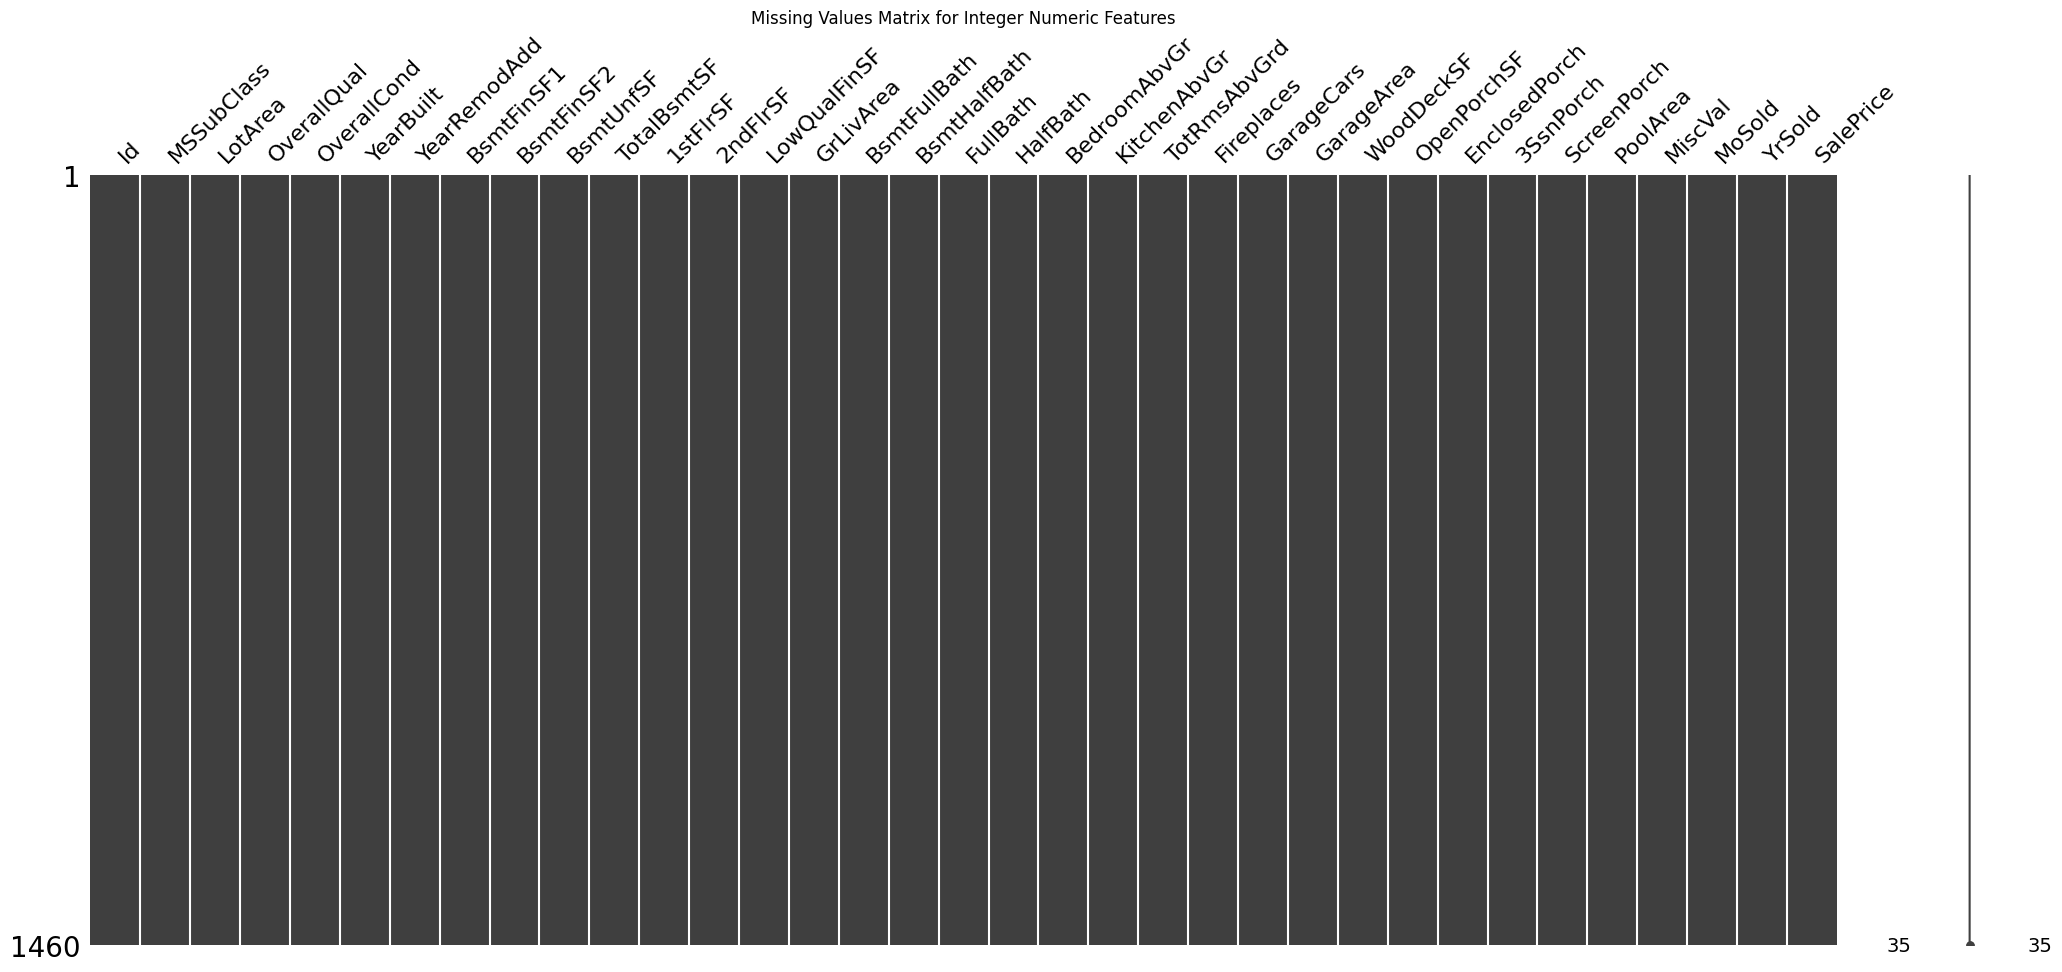

In [490]:
msno.matrix(numeric_features)
plt.title('Missing Values Matrix for Integer Numeric Features')
plt.show()

#### Numeric features of the test dataframe 

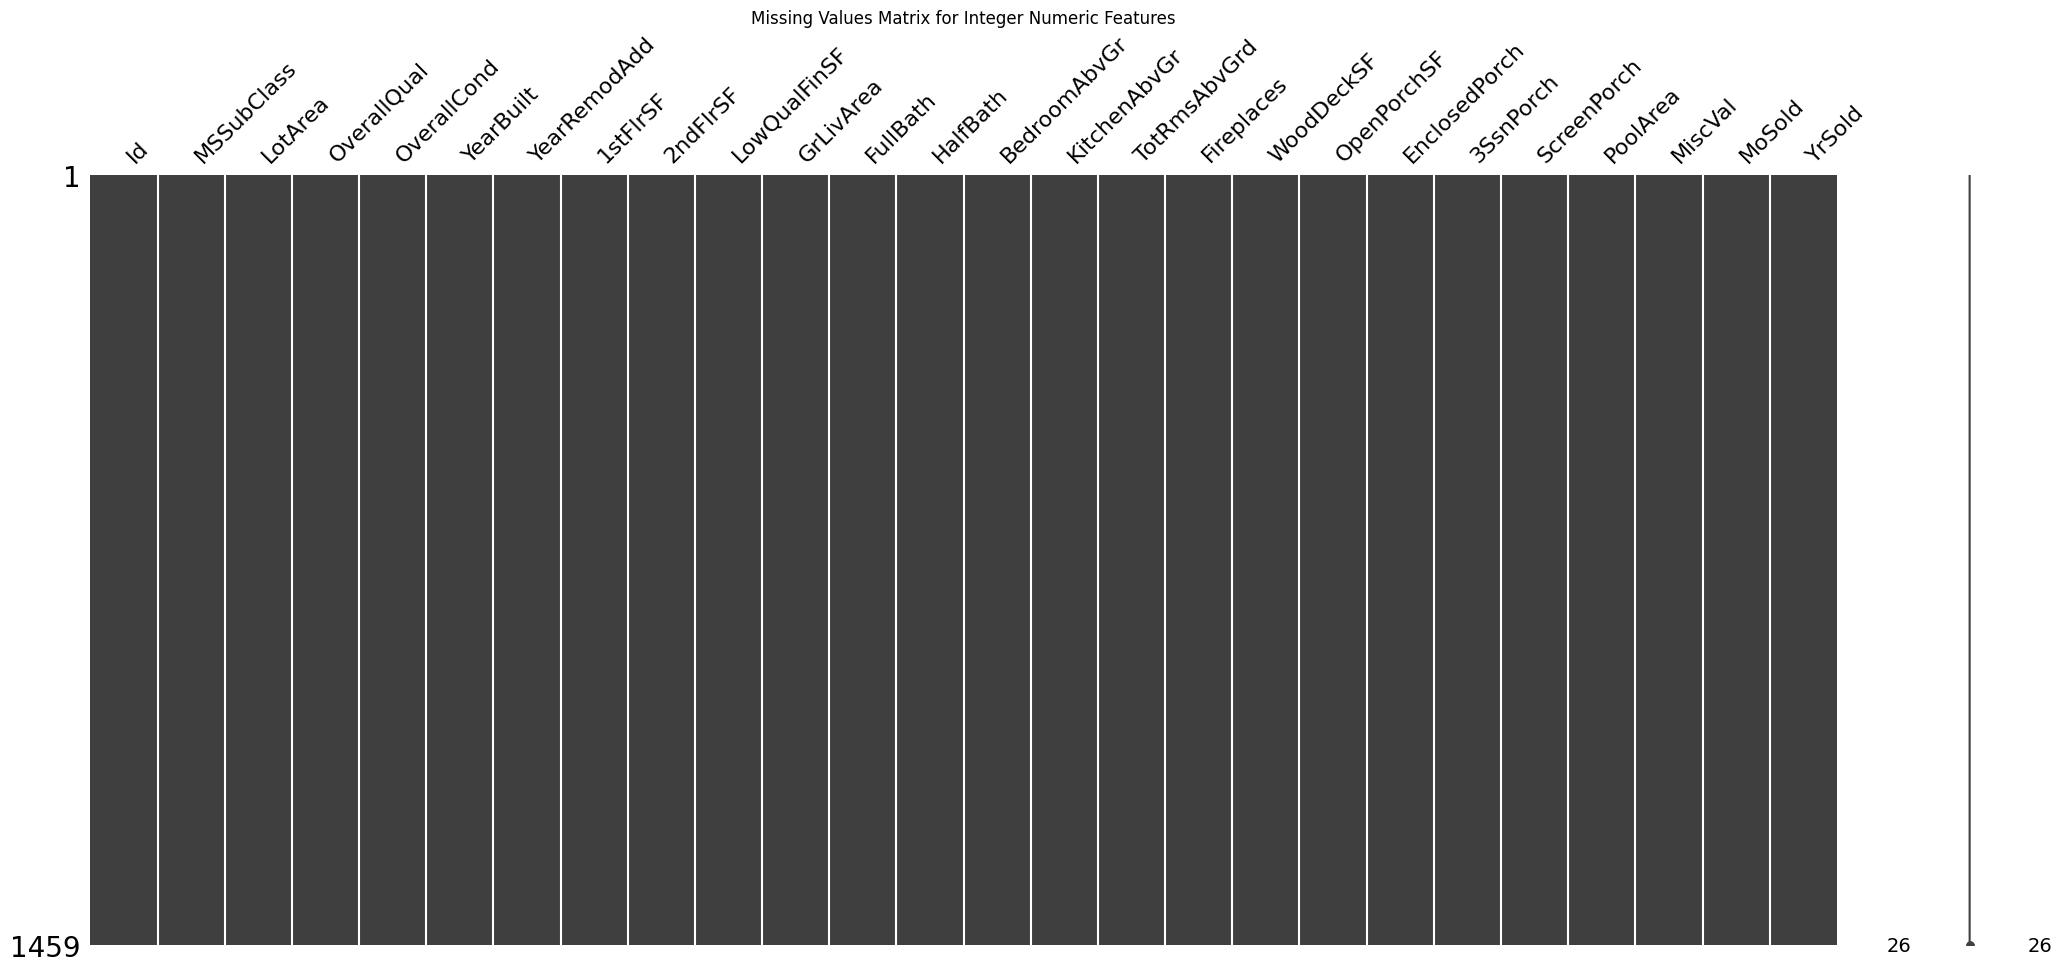

In [491]:
msno.matrix(numeric_features_test)
plt.title('Missing Values Matrix for Integer Numeric Features')
plt.show()

### There are no gaps in the numeric features in the train and the test numeric features, **No missing values**

### Next categorical variables in the train and the test dataframe  

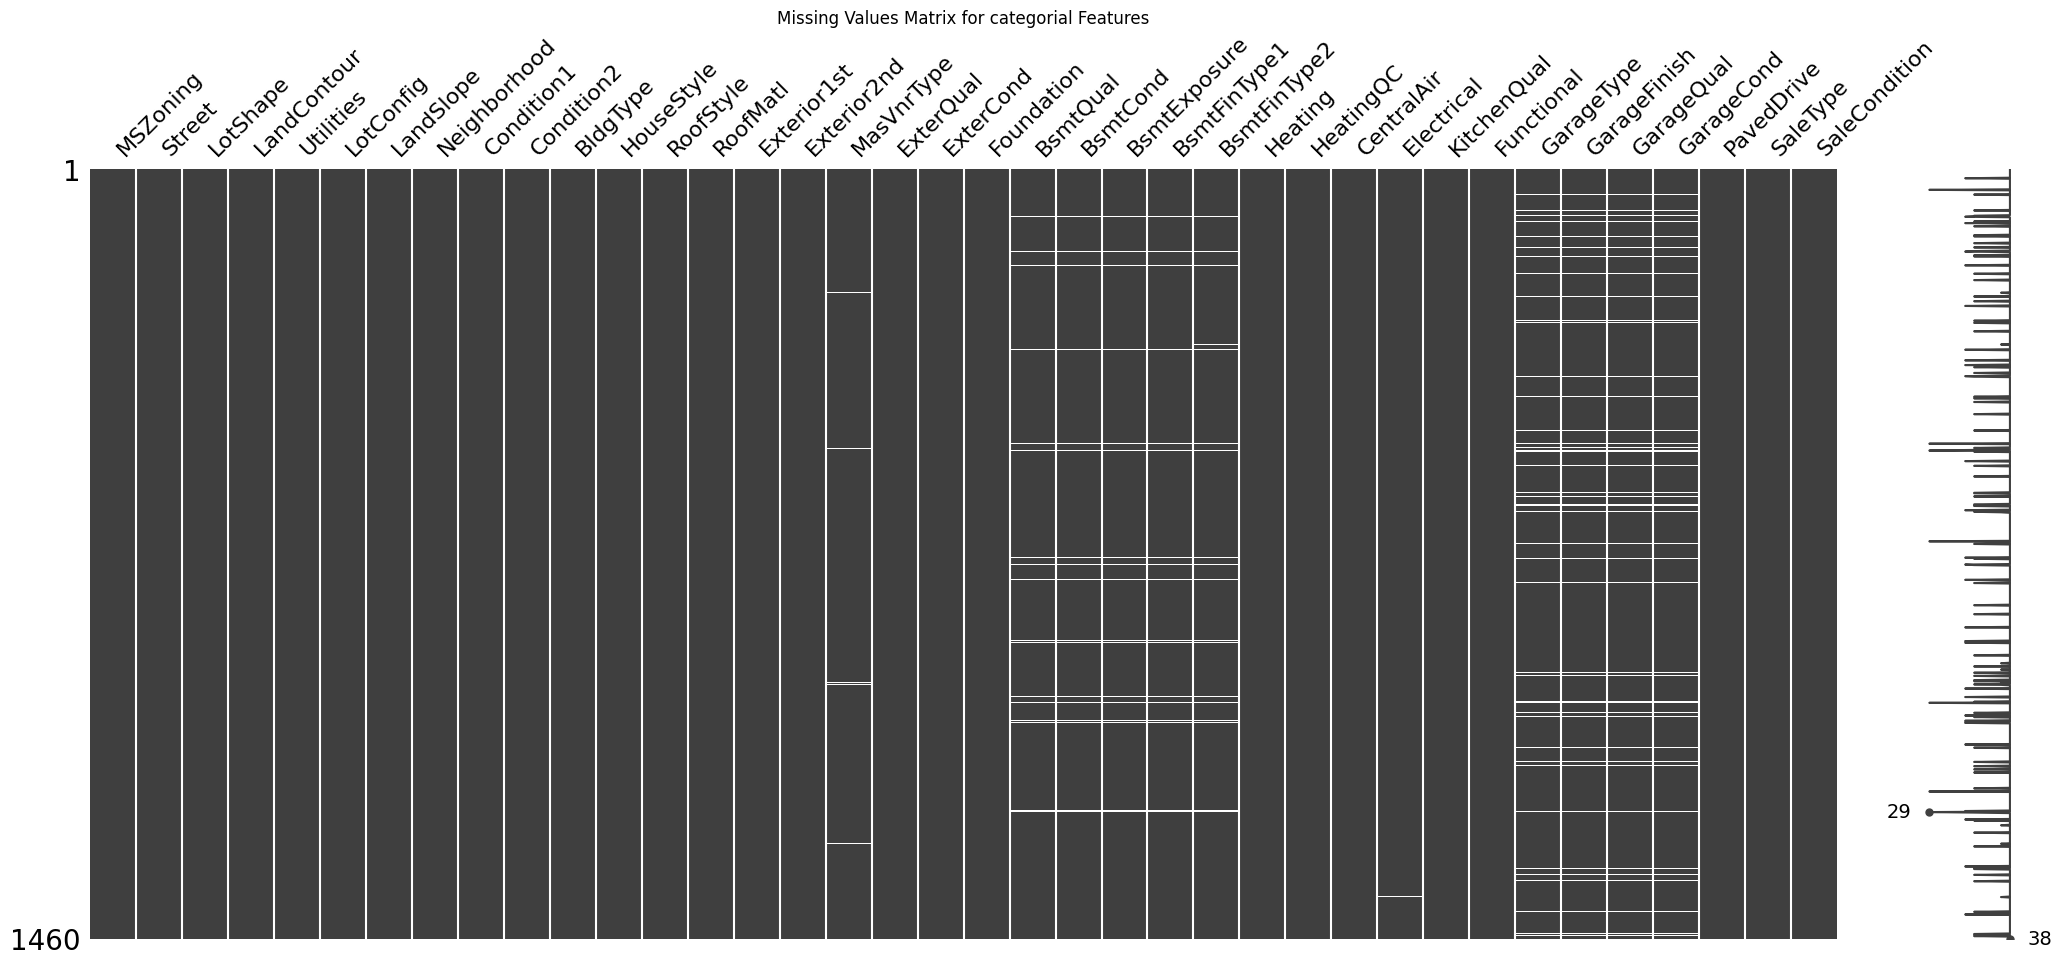

In [492]:
msno.matrix(categorical_features)
plt.title('Missing Values Matrix for categorial Features')
plt.show()

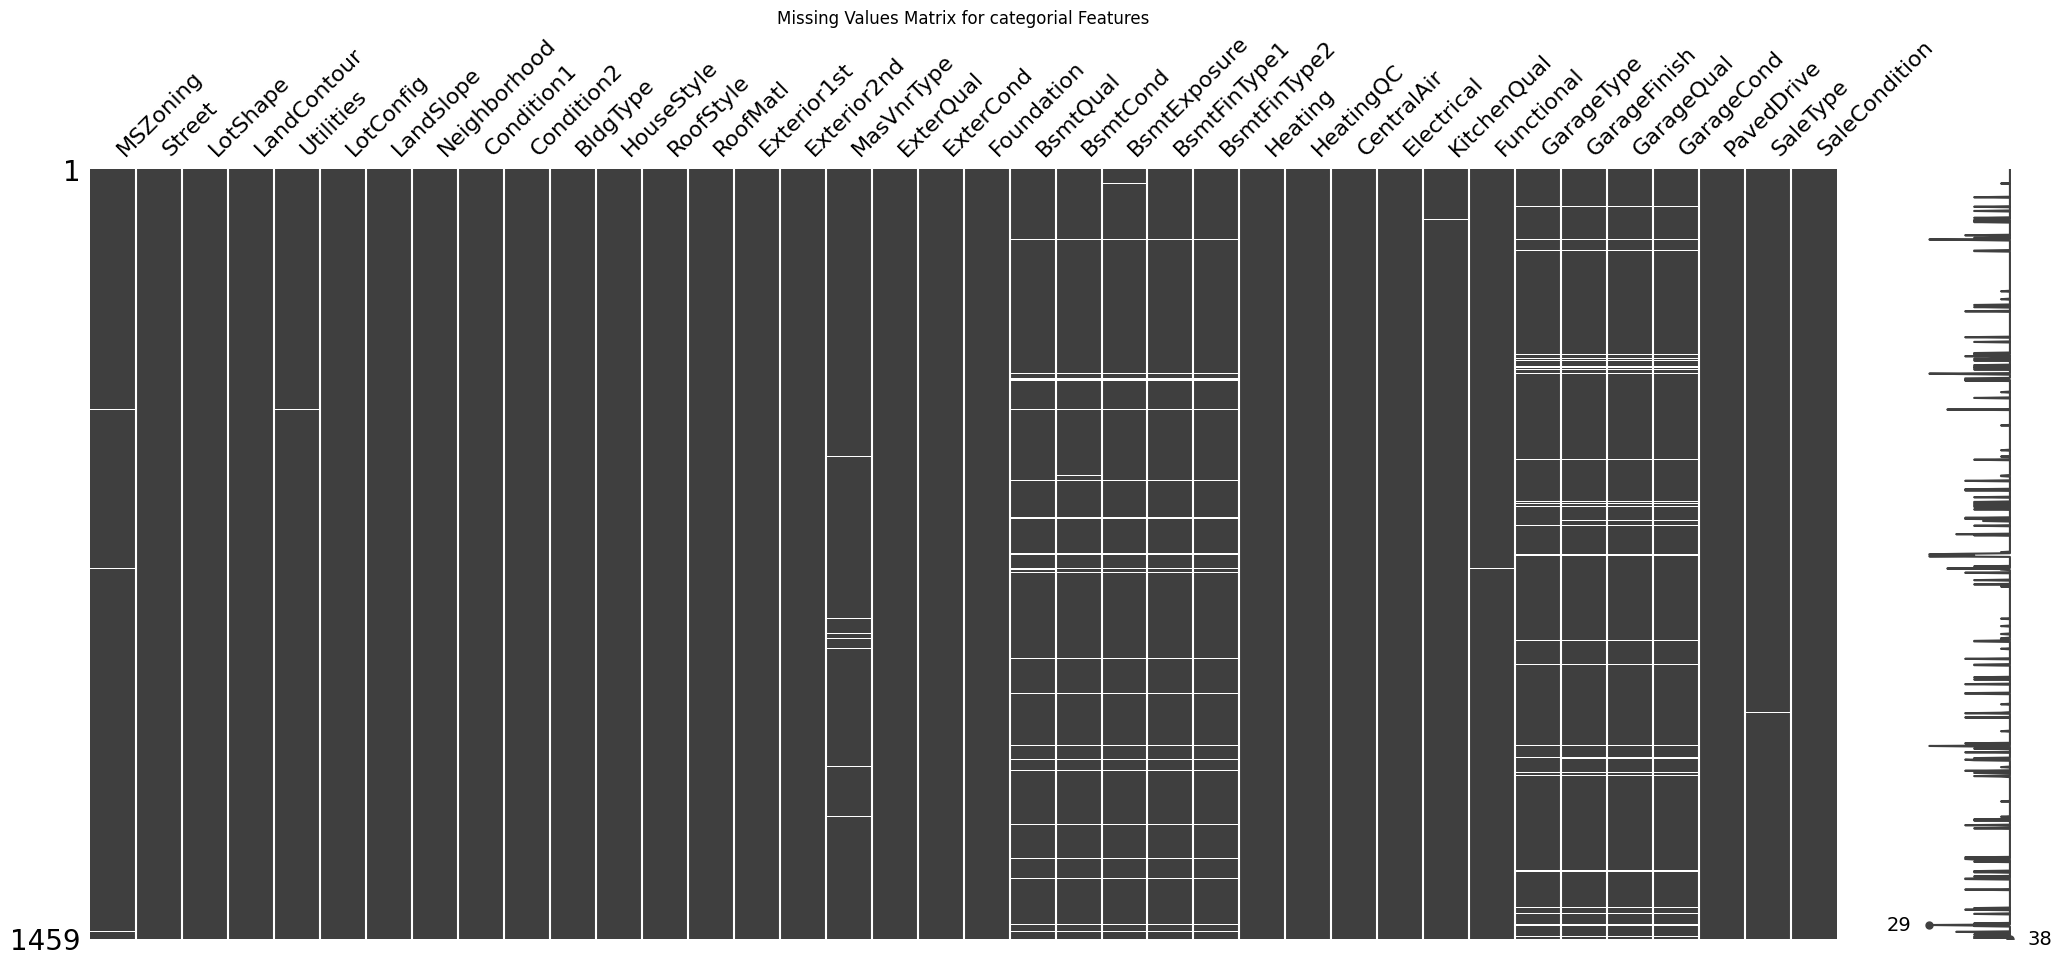

In [493]:
msno.matrix(categorical_features_test)
plt.title('Missing Values Matrix for categorial Features')
plt.show()

### We can see that there are 2 patters of missing values in the categorial data
1. We can notice that  the features the **GarageType,GarageFinish,GarageQual, Garagecond**  values are missing with the **same pattern**
2. We can also notice the features related to the **basement** are missing with the **same pattern**.
3. The rest of the fetautures has **no specfic pattern** for the missing values  
4. The features that have the **same pattern of missing values** belong to the TYPE of **MAR**
5. The features that does **not** have the **same pattern** of missing values belong to the TYPE **NMAR**
6. we can conclude from the above relaizations, that categorial features missing values are a mix between MAR AND NMAR
7. Further reading about the data, **Null values** about the garage and the basement means that the house **doesn't** include a garage ana a basement
 

### Next flaot featues for train and test dataframe 

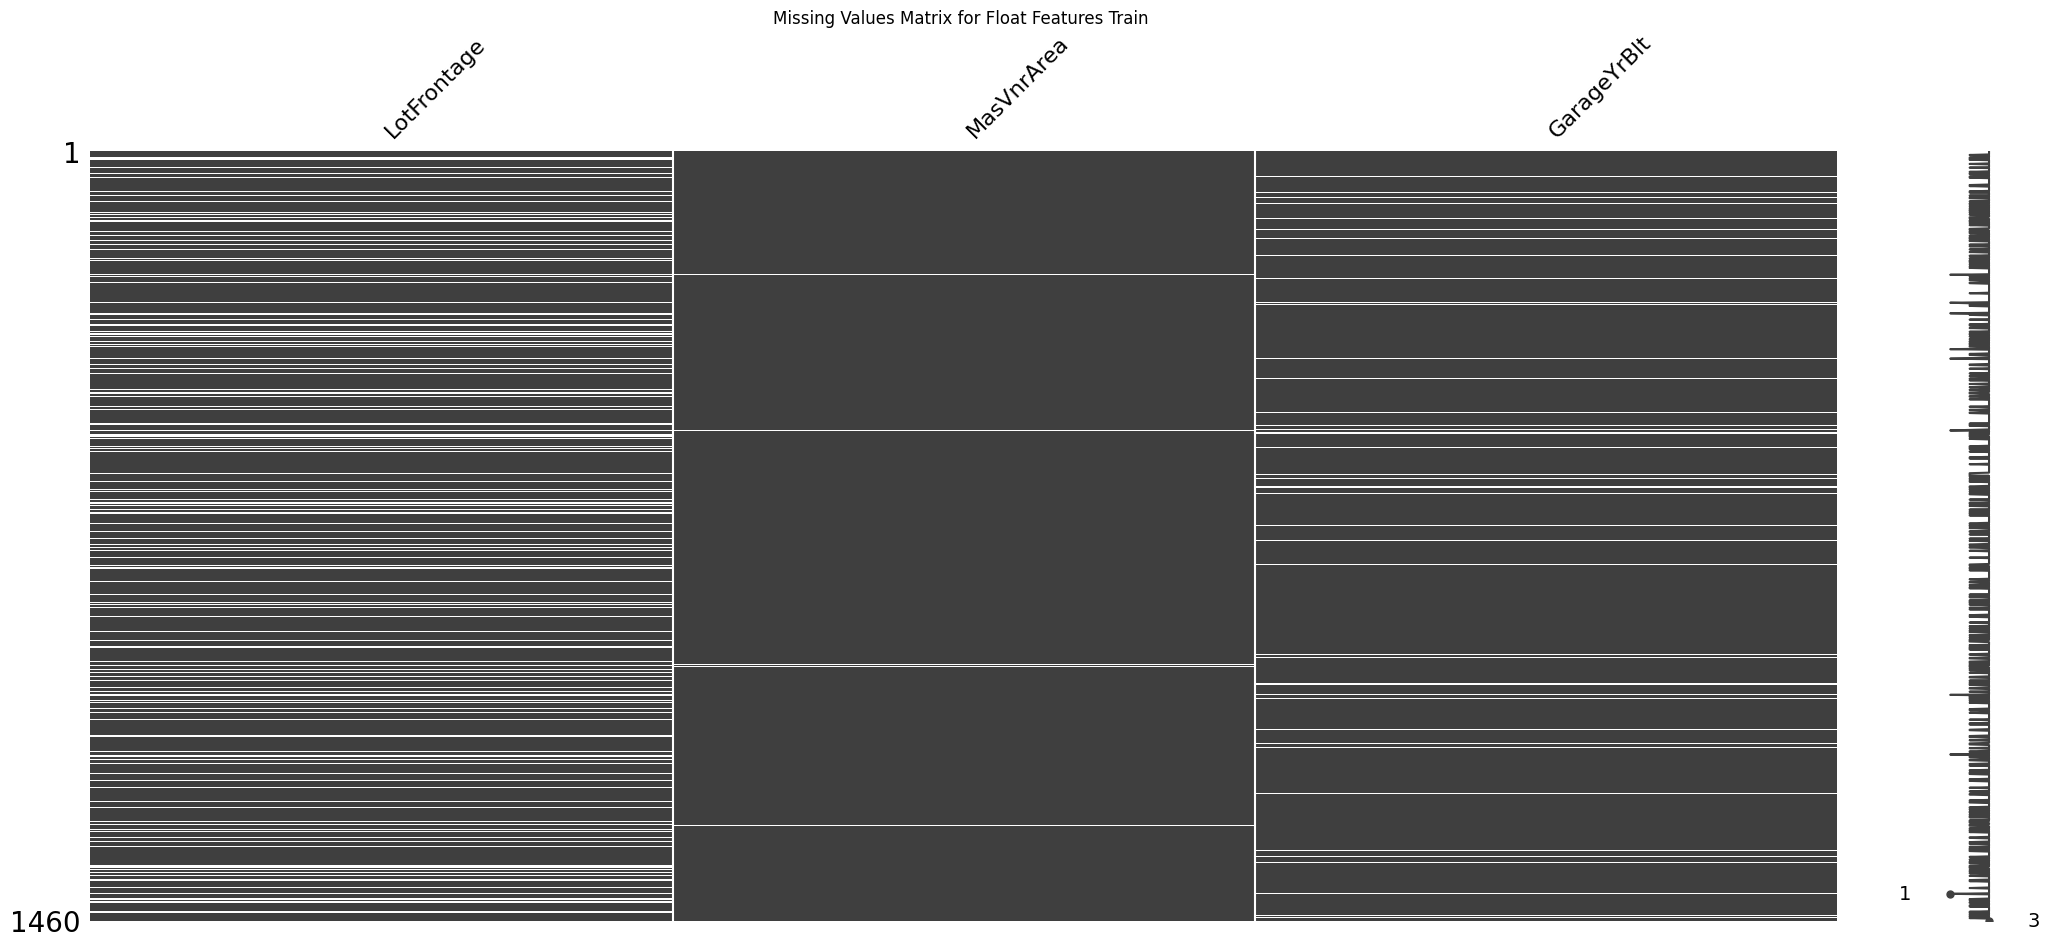

In [494]:
msno.matrix(float_features)
plt.title('Missing Values Matrix for Float Features Train ')
plt.show()

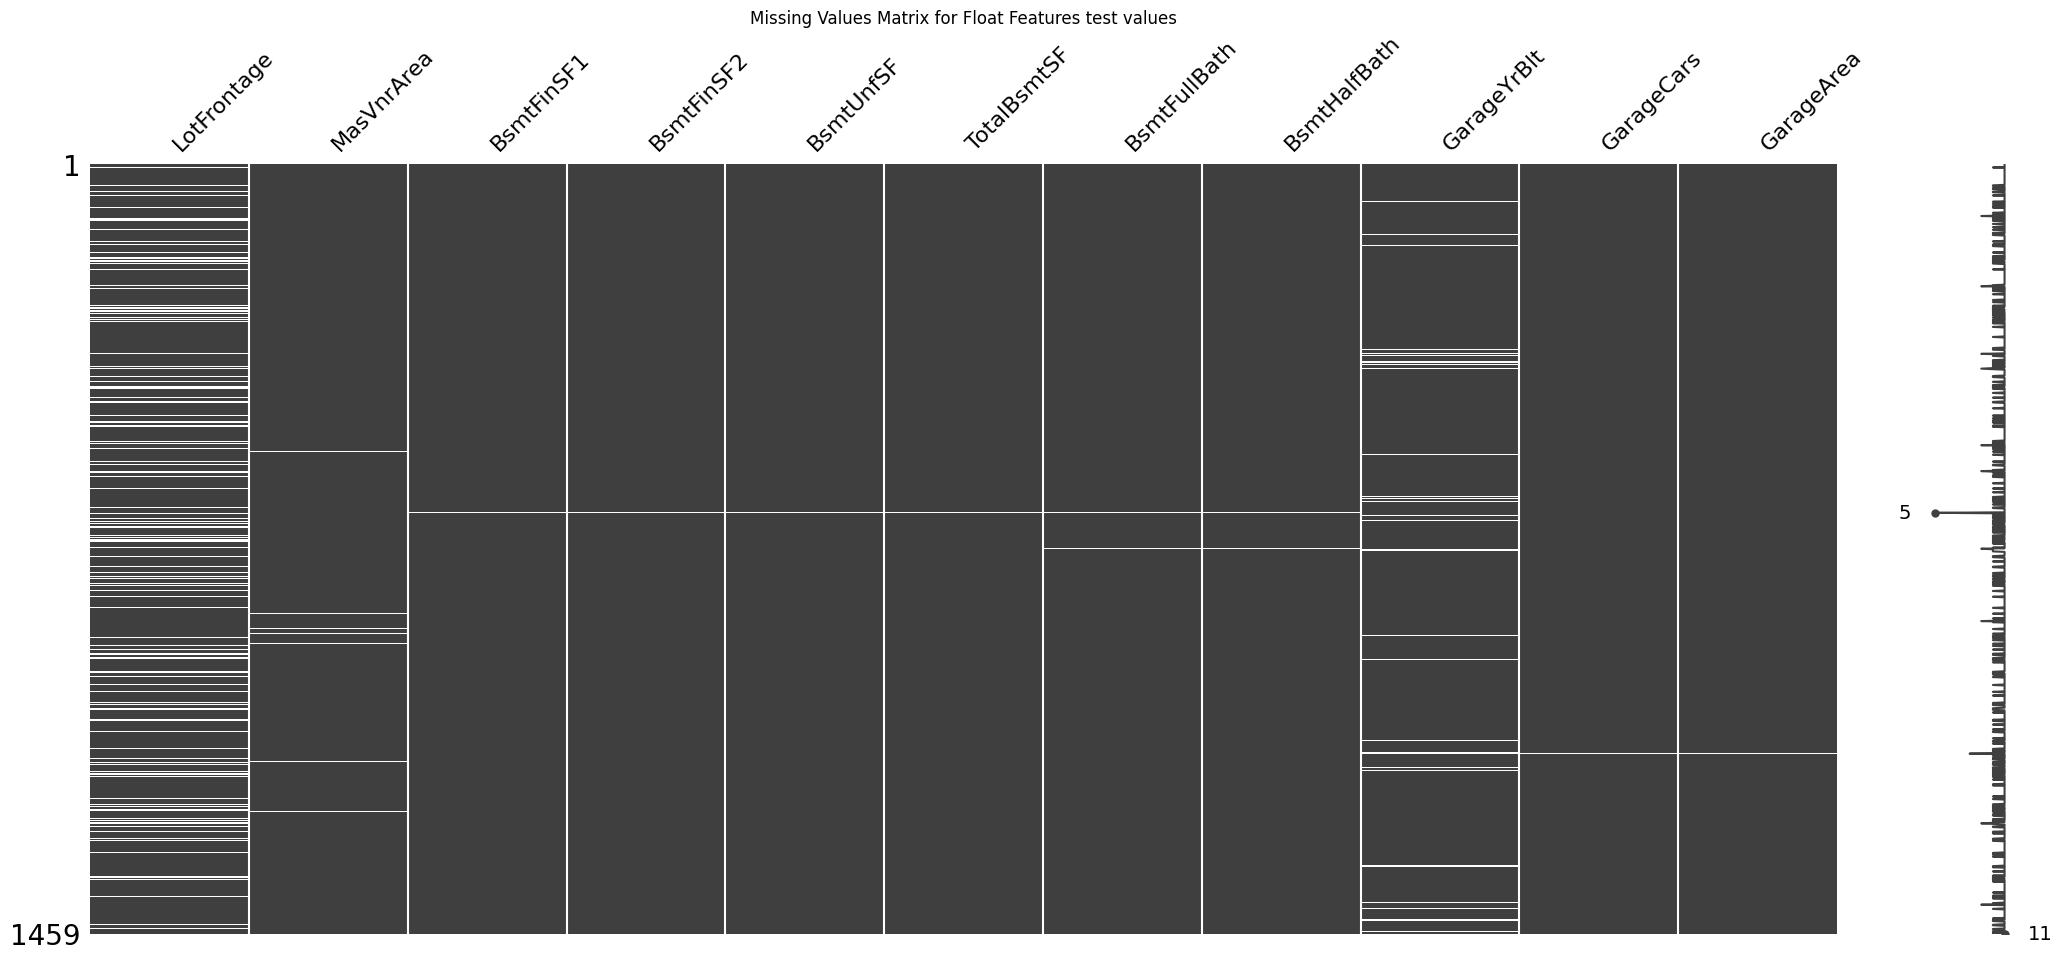

In [495]:
msno.matrix(float_features_test)
plt.title('Missing Values Matrix for Float Features test values')
plt.show()

# In float features, we can notice the following
1. There are **no noticable pattern** between the missing values
2. The probablity of missing values of feature missing value does not depend on other variables.
3. Thus the float features belong to the **MCAR** type of missing values
4. MCAR Missing values --> We can apply **mean** imputation 

## Haandling the Missing values and implmenting Imputation Methods
#### 1. **Numerical_imputer** method takes as input the dataframe, and the strategy, if it is **train** dataframe, then it will define a **new scaler** as well as **imputer** and **fit_transform** the numerical features in the numeric columns. If it is **test** dataframe, then a **scaler and a imputer is passed as arguments** as well and the numerical columns **are just transformed**
#### 2. **categorical_imputer** takes the dataframe and imputes the different feature. The features **where a nan means something**. The imputer **transforms** the Nan into a new cateogory "not there", where **the others features** they take the **mode value**

#### 3. **handling_missing_values** method takes as **input**  the dataframes and calles the different imputers based on wether it is train or test reurns **the datframe with the values imputed** 
 

In [496]:
def numerical_imputer(dataframe, numeric_imputer = None ,numeric_scaler= None, strategy='mean', train = True):
    #X_numeric = dataframe.select_dtypes(include=['float64','int64'])
    numeric_columns = dataframe.select_dtypes(include=['int64', 'float64']).columns
    #print(X_numeric.columns)
    if(train == True):
        imputer = SimpleImputer(strategy=strategy)
        scaler = StandardScaler()
        dataframe[numeric_columns] = imputer.fit_transform(dataframe[numeric_columns])
        dataframe[numeric_columns] = scaler.fit_transform(dataframe[numeric_columns])
        return dataframe, imputer, scaler
    else:
        imputer = numeric_imputer
        scaler = numeric_scaler
        dataframe[numeric_columns] = imputer.transform(dataframe[numeric_columns])
        dataframe[numeric_columns] = scaler.transform(dataframe[numeric_columns])  
        return  dataframe      

In [497]:
def categorical_imputer(dataframe,cat_imputer = None, train = True, fill_value='NOT_THERE'):
    categorial_features_nan_meaning = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2' , 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
    categorial_features_nan_no_meaning =['MasVnrType','Electrical']
    for feature in categorial_features_nan_meaning :
        dataframe[feature] = dataframe[feature].fillna("NOT_THERE")
    if(train == True):
        cat_imputer = SimpleImputer(strategy='most_frequent')
        dataframe[categorial_features_nan_no_meaning] = cat_imputer.fit_transform(dataframe[categorial_features_nan_no_meaning ])
        return dataframe,cat_imputer
    else:
        dataframe[categorial_features_nan_no_meaning] = cat_imputer.transform(dataframe[categorial_features_nan_no_meaning ])
        return dataframe 



In [498]:
def handling_missing_values(dataframe,scaler = None,imputer = None,cat_imputer = None, train = True):
    if(train == True):    
        dataframe, imputer, scaler = numerical_imputer(dataframe)
        dataframe, cat_imputer = categorical_imputer(dataframe)
        #dataframe,label_encoder = transform_categorial_classes(dataframe,None)
        return dataframe, imputer,scaler,cat_imputer
    else:
        dataframe  = numerical_imputer(dataframe,imputer, scaler, train = False)
        dataframe =  categorical_imputer(dataframe,cat_imputer, train = False )
        #dataframe = transform_categorial_classes(dataframe,None,train = False)
        return dataframe
y = df_train['SalePrice'] 
df_train =  df_train.drop(['SalePrice','Id'], axis =1) 
df_test_id = df_test['Id']
df_test =  df_test.drop(['Id'], axis =1)   
df_train,num_imputer,scaler,cat_imputer = handling_missing_values(df_train,scaler = None,imputer = None,cat_imputer = None, train = True)
df_test = handling_missing_values(df_test,scaler,imputer = num_imputer,cat_imputer = cat_imputer, train = False)



#### Now we extract the different data from the imputed data frames and make sure that there are no missing values

In [499]:
categorical_features_imputated,numeric_features_imputated,float_features_imputated = features_types(df_train)
categorical_features_test,numeric_features_test,float_features_test = features_types(df_test)

Number of categorial features:38 
Number of numeric features:0
num_of_float_features:36
Number of categorial features:38 
Number of numeric features:0
num_of_float_features:36


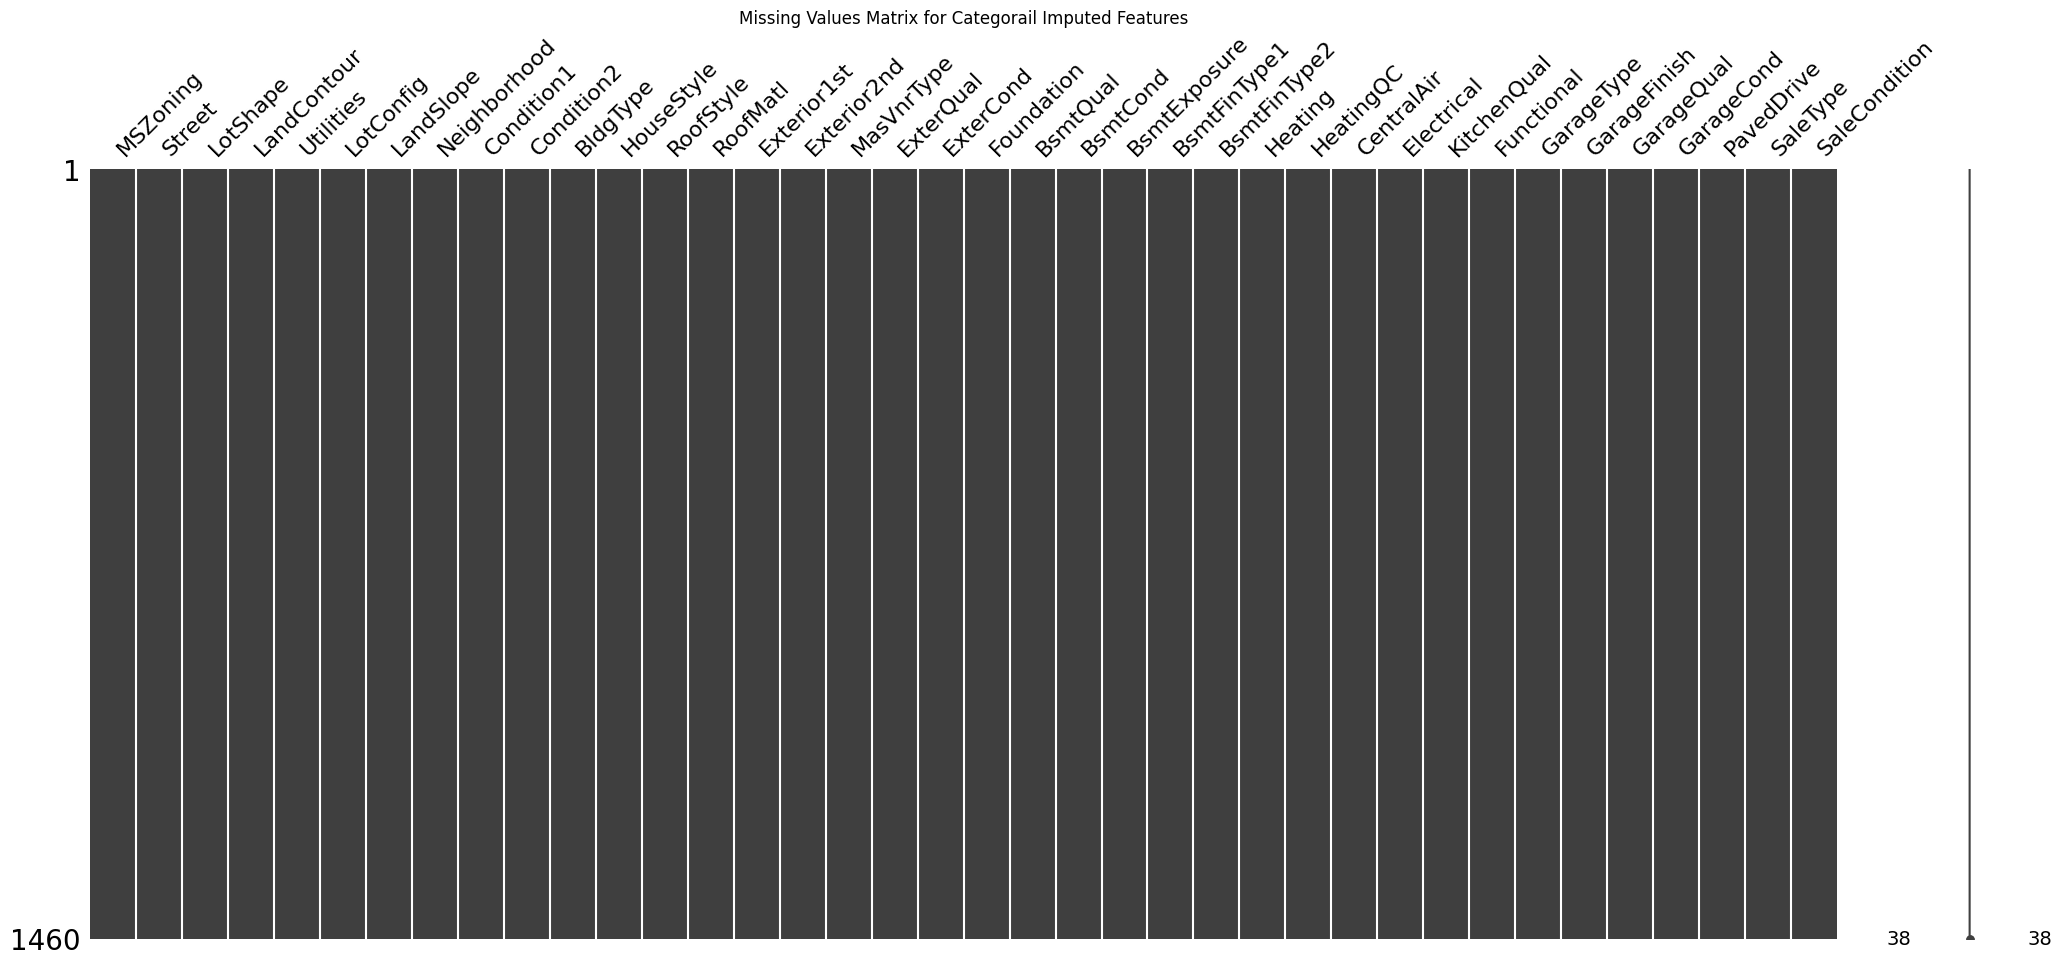

In [500]:
msno.matrix(categorical_features_imputated)
plt.title('Missing Values Matrix for Categorail Imputed Features')
plt.show()

 

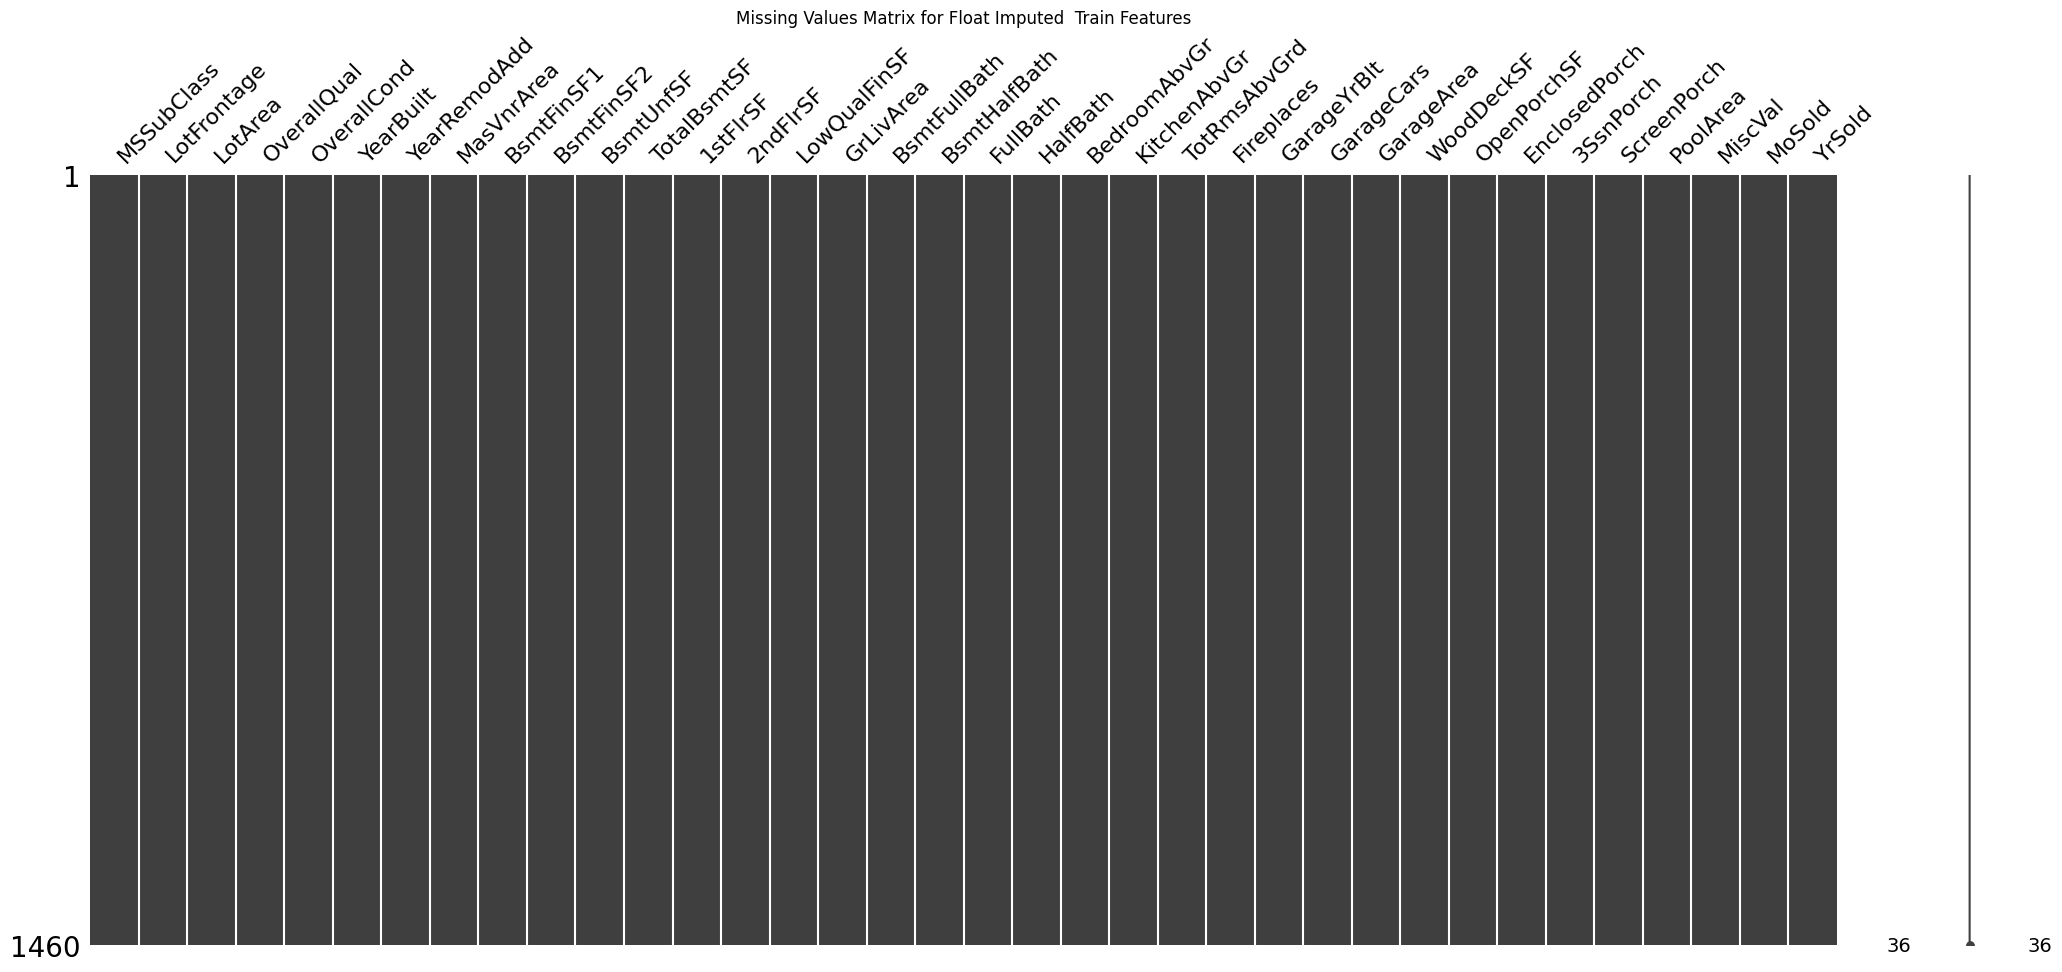

In [501]:
msno.matrix(float_features_imputated)
plt.title('Missing Values Matrix for Float Imputed  Train Features')
plt.show()

### It can be seen that there are **no missing values** in the above visulaizations, we can now move to the model part

### Now we need to transform the catgorial classes of the train and the test dataframe
#### **transform_cattegorial_classes** methods takes as **input** the dataframe as well as the label encode in cast of the test dataframe and **returns** the dataframe with the encoded categoral classes

In [502]:
def transform_categorial_classes(df, labelencoder,train = True):
    if(labelencoder != None):
        le = labelencoder
    else:       
        le=LabelEncoder()
    for column in df.columns:
        if df[column].dtype=='object':
            df[column]=le.fit_transform(df[column])
    if train == True:        
        return df,le
    else:
        return df    
df_train,label_encoder = transform_categorial_classes(df_train, labelencoder = None,train = True)
df_test = transform_categorial_classes(df_test, labelencoder = label_encoder,train = False)


#### **Linear_reg_model** method takes as **input** the dataframe for train, the test size and the target reg variable. It **returns** the lr regression model 
#### **xgboost_regression_model** method uses xgboost regression model and takes as **input** the dataframe train, test_size, target_variable, and the test dataset. It **returns** the xgbmodel and the predictions for the test dataset
#### we use the **plot importance** to see the most important features  

In [510]:
def linear_regression_model(dataframe_features, test_size,y):
    y = np.log(y)
    x_train,x_val,y_train,y_val=train_test_split(dataframe_features,y,test_size=test_size,random_state = 42)
    lr=LinearRegression()
    lr.fit(x_train,y_train)
    y_pred=lr.predict(x_val)
    rms = mean_squared_error(y_val, y_pred,squared=False)
    print(f"Mean squared error:{rms}")
    acc=lr.score(x_val,y_val)
    print(f"Acc is {acc}")
    return lr




linear_reg_model = linear_regression_model(df_train, 0.3,y)
predictions_using_linear_reg_model = linear_reg_model.predict(df_test)







Mean squared error:0.15149566360365443
Acc is 0.8647129094161976


The mean squared error: 0.14040327884058246
Acc is 0.8837988426681725


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

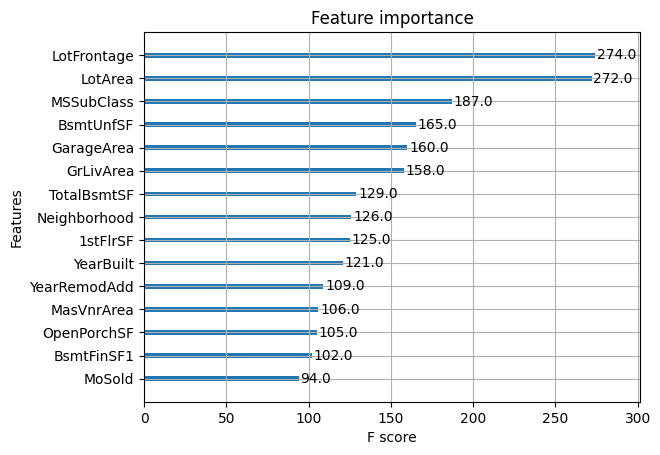

In [515]:
def xgboost_regression_model(dataframe_features, test_size,y,test = df_test,df_test_id = df_test_id):
    y = np.log(y)
    xgb = xgboost.XGBRegressor(objective = 'reg:squarederror')
    x_train,x_val,y_train,y_val=train_test_split(dataframe_features,y,test_size=test_size,random_state = 42)
    xgb.fit(x_train, y_train)
    y_pred = xgb.predict(x_val)
    rms = mean_squared_error(y_val,y_pred, squared=False)
    print(f"The mean squared error: {rms}")
    acc=xgb.score(x_val,y_val)
    print(f"Acc is {acc}")
    sales_pred = xgb.predict(df_test)
    submission = pd.DataFrame({'Id': df_test_id, 'sales_pred': sales_pred})
    submission['sales_pred'] = np.exp(submission['sales_pred'])
    return xgb,submission 

xgb_reg_model,submission_df = xgboost_regression_model(df_train, 0.3,y)
xgboost.plot_importance(xgb_reg_model, max_num_features = 15)
